<a href="https://colab.research.google.com/github/jku-win-dke/SemAI/blob/main/V10_KGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Graph Embeddings

This notebook is about your first steps with knowledge graph embedding models in PyKEEN. This notebook is based on https://github.com/pykeen/pykeen/blob/master/notebooks/hello_world/hello_world.ipynb

You'll get to do the following:

1. train a model based on a small knowledge graph
2. evaluate how good it learned
3. turn it around and start making predictions.

The knowledge graph is provided inline as string and is originally based on the `Countries` dataset provided with Pykeen.


## Install Packages

In [1]:
# Install packages if they're not already found
! pip install --upgrade pip
! python -c "import pykeen" || pip install git+https://github.com/pykeen/pykeen.git
! python -c "import wordcloud" || pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'pykeen'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pykeen/pykeen.git to /tmp/pip-req-build-1om23iiw
  Running command git clone --filter=blob:none --quiet https://github.com/pykeen/pykeen.git /tmp/pip-req-build-1om23iiw
  Resolved https://github.com/pykeen/pykeen.git to commit cb226fc1ff946f0bc6c1296ea5d3ee87a4ef773b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... do

## Imports

In [2]:
import os

import matplotlib.pyplot as plt
import torch

import pykeen
from pykeen.datasets import Countries
from pykeen.pipeline import pipeline
from pykeen import predict
from pykeen.triples import TriplesFactory

import requests
import numpy as np

import pandas as pd

pd.set_option('display.max_columns', 100)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

INFO:pykeen.utils:Using opt_einsum


## Environment variables

In [3]:
pykeen.env()

Key,Value
OS,posix
Platform,Linux
Release,5.15.107+
Time,Thu Jun 15 04:27:38 2023
Python,3.10.12
PyKEEN,1.10.2-dev
PyKEEN Hash,UNHASHED
PyKEEN Branch,
PyTorch,2.0.1+cu118
CUDA Available?,false


## The Knowledge Graph

The knowledge graph is provided inline as String to facilitate manipulation. You can add and delete triples as you wish. You have to separate subject, predicate and objects by tabs.

In the current KG, Switzerland has no information about which part of europe it is located in and its languages.

In [4]:
data = """
albania	language	albanian
albania	language	macedonian
albania	language	greek
albania	locatedin	southern_europe
albania	neighbor	greece
albania	neighbor	kosovo
albania	neighbor	macedonia
albania	neighbor	montenegro
andorra	language	catalan
andorra	locatedin	southern_europe
andorra	neighbor	france
andorra	neighbor	spain
austria	language	croatian
austria	language	german
austria	language	hungarian
austria	language	slovene
austria	locatedin	western_europe
austria	neighbor	czechia
austria	neighbor	germany
austria	neighbor	hungary
austria	neighbor	italy
austria	neighbor	liechtenstein
austria	neighbor	slovakia
belarus	language	belarussian
belarus	language	russian
belarus	locatedin	eastern_europe
belarus	neighbor	latvia
belarus	neighbor	lithuania
belarus	neighbor	poland
belarus	neighbor	russia
belarus	neighbor	ukraine
belgium	language	dutch
belgium	language	french
belgium	language	german
belgium	locatedin	western_europe
belgium	neighbor	france
belgium	neighbor	germany
belgium	neighbor	luxembourg
belgium	neighbor	netherlands
bosnia_and_herzegovina	language	bosnian
bosnia_and_herzegovina	language	croation
bosnia_and_herzegovina	language	serbian
bosnia_and_herzegovina	locatedin	southern_europe
bosnia_and_herzegovina	neighbor	croatia
bosnia_and_herzegovina	neighbor	montenegro
bosnia_and_herzegovina	neighbor	serbia
bulgaria	language	bulgarian
bulgaria	locatedin	eastern_europe
bulgaria	neighbor	greece
bulgaria	neighbor	macedonia
bulgaria	neighbor	romania
bulgaria	neighbor	serbia
bulgaria	neighbor	turkey
croatia	language	croatian
croatia	locatedin	southern_europe
croatia	neighbor	bosnia_and_herzegovina
croatia	neighbor	hungary
croatia	neighbor	montenegro
croatia	neighbor	serbia
croatia	neighbor	slovenia
cyprus	language	greek
cyprus	language	turkish
cyprus	locatedin	eastern_europe
cyprus	neighbor	united_kingdom
czechia	language	czech
czechia	locatedin	eastern_europe
czechia	neighbor	austria
czechia	neighbor	germany
czechia	neighbor	poland
czechia	neighbor	slovakia
denmark	language	danish
denmark	language	german
denmark	locatedin	northern_europe
denmark	neighbor	germany
estonia	language	estonian
estonia	locatedin	northern_europe
estonia	neighbor	latvia
estonia	neighbor	russia
finland	language	finnish
finland	language	swedish
finland	locatedin	northern_europe
finland	neighbor	norway
finland	neighbor	russia
finland	neighbor	sweden
france	language	french
france	locatedin	western_europe
france	neighbor	andorra
france	neighbor	belgium
france	neighbor	germany
france	neighbor	italy
france	neighbor	luxembourg
france	neighbor	monaco
france	neighbor	spain
france	neighbor	switzerland
germany	language	german
germany	locatedin	western_europe
germany	neighbor	austria
germany	neighbor	belgium
germany	neighbor	czechia
germany	neighbor	denmark
germany	neighbor	france
germany	neighbor	luxembourg
germany	neighbor	netherlands
germany	neighbor	poland
germany	neighbor	switzerland
gibraltar	language	english
gibraltar	language	spanish
gibraltar	locatedin	southern_europe
gibraltar	neighbor	spain
greece	language	greek
greece	locatedin	southern_europe
greece	neighbor	albania
greece	neighbor	bulgaria
greece	neighbor	macedonia
greece	neighbor	turkey
hungary	language	hungarian
hungary	locatedin	eastern_europe
hungary	neighbor	austria
hungary	neighbor	croatia
hungary	neighbor	romania
hungary	neighbor	serbia
hungary	neighbor	slovakia
hungary	neighbor	slovenia
hungary	neighbor	ukraine
iceland	language	icelandic
iceland	locatedin	northern_europe
ireland	locatedin	northern_europe
ireland	neighbor	united_kingdom
italy	language	italian
italy	locatedin	southern_europe
italy	neighbor	austria
italy	neighbor	france
italy	neighbor	san_marino
italy	neighbor	slovenia
italy	neighbor	switzerland
italy	neighbor	vatican_city
kosovo	language	albanian
kosovo	language	serbian
kosovo	locatedin	eastern_europe
kosovo	neighbor	albania
kosovo	neighbor	macedonia
kosovo	neighbor	montenegro
kosovo	neighbor	serbia
latvia	language	latvian
latvia	locatedin	northern_europe
latvia	neighbor	belarus
latvia	neighbor	estonia
latvia	neighbor	lithuania
latvia	neighbor	russia
liechtenstein	language	german
liechtenstein	locatedin	western_europe
liechtenstein	neighbor	austria
liechtenstein	neighbor	switzerland
lithuania	language	lithuanian
lithuania	locatedin	northern_europe
lithuania	neighbor	belarus
lithuania	neighbor	latvia
lithuania	neighbor	poland
lithuania	neighbor	russia
luxembourg	language	french
luxembourg	language	german
luxembourg	language	luxembourgish
luxembourg	locatedin	western_europe
luxembourg	neighbor	belgium
luxembourg	neighbor	france
luxembourg	neighbor	germany
macedonia	language	albanian
macedonia	language	macedonian
macedonia	locatedin	southern_europe
macedonia	neighbor	albania
macedonia	neighbor	bulgaria
macedonia	neighbor	greece
macedonia	neighbor	kosovo
macedonia	neighbor	serbia
malta	language	english
malta	language	maltese
malta	locatedin	southern_europe
moldova	language	romanian
moldova	locatedin	eastern_europe
moldova	neighbor	romania
moldova	neighbor	ukraine
monaco	language	french
monaco	language	italian
monaco	locatedin	western_europe
monaco	neighbor	france
montenegro	language	montenegrin
montenegro	language	albanian
montenegro	language	bosnian
montenegro	language	croatian
montenegro	language	serbian
montenegro	locatedin	southern_europe
montenegro	neighbor	albania
montenegro	neighbor	bosnia_and_herzegovina
montenegro	neighbor	croatia
montenegro	neighbor	kosovo
montenegro	neighbor	serbia
netherlands	language	dutch
netherlands	locatedin	western_europe
netherlands	neighbor	belgium
netherlands	neighbor	germany
norway	language	norwegian
norway	locatedin	northern_europe
norway	neighbor	finland
norway	neighbor	russia
norway	neighbor	sweden
poland	language	polish
poland	locatedin	eastern_europe
poland	neighbor	belarus
poland	neighbor	czechia
poland	neighbor	germany
poland	neighbor	lithuania
poland	neighbor	russia
poland	neighbor	slovakia
poland	neighbor	ukraine
portugal	language	portuguese
portugal	locatedin	southern_europe
portugal	neighbor	spain
romania	language	romanian
romania	locatedin	eastern_europe
romania	neighbor	bulgaria
romania	neighbor	hungary
romania	neighbor	moldova
romania	neighbor	serbia
romania	neighbor	ukraine
russia	language	russian
russia	locatedin	eastern_europe
russia	neighbor	belarus
russia	neighbor	estonia
russia	neighbor	finland
russia	neighbor	latvia
russia	neighbor	lithuania
russia	neighbor	norway
russia	neighbor	poland
russia	neighbor	ukraine
san_marino	language	italian
san_marino	locatedin	southern_europe
san_marino	neighbor	italy
serbia	language	serbian
serbia	locatedin	southern_europe
serbia	neighbor	bosnia_and_herzegovina
serbia	neighbor	bulgaria
serbia	neighbor	croatia
serbia	neighbor	hungary
serbia	neighbor	kosovo
serbia	neighbor	macedonia
serbia	neighbor	montenegro
serbia	neighbor	romania
slovakia	language	slovak
slovakia	locatedin	central_europe
slovakia	neighbor	austria
slovakia	neighbor	czechia
slovakia	neighbor	hungary
slovakia	neighbor	poland
slovakia	neighbor	ukraine
slovenia	language	hungarian
slovenia	language	italian
slovenia	language	slovene
slovenia	locatedin	southern_europe
slovenia	neighbor	austria
slovenia	neighbor	croatia
slovenia	neighbor	hungary
slovenia	neighbor	italy
spain	language	spanish
spain	language	catalan
spain	locatedin	southern_europe
spain	neighbor	andorra
spain	neighbor	france
spain	neighbor	gibraltar
spain	neighbor	morocco
spain	neighbor	portugal
sweden	language	swedish
sweden	language	finnish
sweden	locatedin	northern_europe
sweden	neighbor	finland
sweden	neighbor	norway
switzerland	neighbor	france
switzerland	neighbor	germany
switzerland	neighbor	italy
switzerland	neighbor	liechtenstein
turkey	language	turkish
turkey	neighbor	bulgaria
turkey	neighbor	greece
ukraine	language	ukrainian
ukraine	language	russian
ukraine	locatedin	eastern_europe
ukraine	locatedin	eastern_europe
ukraine	neighbor	belarus
ukraine	neighbor	hungary
ukraine	neighbor	moldova
ukraine	neighbor	poland
ukraine	neighbor	romania
ukraine	neighbor	russia
ukraine	neighbor	slovakia
united_kingdom	language	english
united_kingdom	locatedin	northern_europe
united_kingdom	neighbor	ireland
vatican_city	language	latin
vatican_city	language	italian
vatican_city	locatedin	southern_europe
vatican_city	neighbor	italy
""".strip()

### Triple Factories

The data is to be split up in a training set and a testing set and provided as triple factories.

In [5]:
def get_tf(triples):
  triples = np.array([triple.split("\t") for triple in triples.split("\n")])
  tf = TriplesFactory.from_labeled_triples(triples=triples)
  return tf

data_tf = get_tf(data)
train_tf, test_tf = data_tf.split()

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [176, 60]


## Train a Model

We use PyKeen's `pipeline` to learn a knowledge graph embedding from the dataset.

More tutorials on training your first model can be found [here](https://pykeen.readthedocs.io/en/latest/tutorial/first_steps.html).

In [6]:
result = pipeline(
    training=train_tf,
    testing=test_tf,
    model="PairRE",

    # Training configuration
    training_kwargs=dict(
        num_epochs=200,
        use_tqdm_batch=False,
    ),
    # Runtime configuration
    random_seed=1235,
)

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/60.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds


## Internals

Save the trained model (which contains the triples and all of the learned parameters), the results from training, and all of the experimental metadata.

In [7]:
save_location = "results"  # this directory
result.save_to_directory(save_location)
os.listdir(save_location)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=92, num_relations=3, create_inverse_triples=False, num_triples=239) to file:///content/results/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /content/results


['results.json', 'metadata.json', 'training_triples', 'trained_model.pkl']

In [8]:
# How to look at the model
model = result.model
model

PairRE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): PairREInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(92, 200)
    )
  )
  (relation_representations): ModuleList(
    (0-1): 2 x Embedding(
      (_embeddings): Embedding(3, 200)
    )
  )
  (weight_regularizers): ModuleList()
)

In [9]:
# How to look at the triples
tf = result.training
tf

TriplesFactory(num_entities=92, num_relations=3, create_inverse_triples=False, num_triples=239)

In [10]:
tf.num_entities, tf.num_relations, tf.num_triples

(92, 3, 239)

## Evaluating the Results

Check that the loss is going down (and not oscillating) by plotting in the notebook.

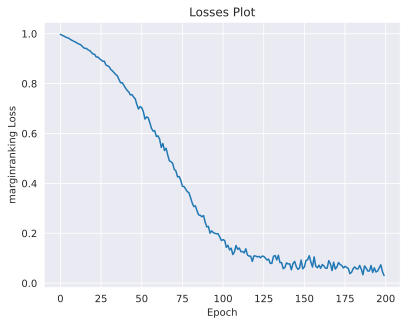

In [11]:
result.plot_losses()
plt.show()

Look at the result. These are pretty tricky to interpret, so remember:

- adjusted mean rank is between [0, 2]. Closer to 0 is better!
- mean rank is a positive integer, with a bound based on the number of entities. Closer to 0 is better!
- hits@k is reported between [0, 1] and interpreted as a percentage. Closer to 1 is better!

In [12]:
result.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,adjusted_inverse_harmonic_mean_rank,0.541200
1,tail,optimistic,adjusted_inverse_harmonic_mean_rank,0.629670
2,both,optimistic,adjusted_inverse_harmonic_mean_rank,0.585465
3,head,realistic,adjusted_inverse_harmonic_mean_rank,0.541200
4,tail,realistic,adjusted_inverse_harmonic_mean_rank,0.629670
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.830934
221,both,realistic,adjusted_hits_at_k,0.802398
222,head,pessimistic,adjusted_hits_at_k,0.773759
223,tail,pessimistic,adjusted_hits_at_k,0.830934


## Turn it around: make predictions

It's very difficult to interpret KGEMs statistically, so it's best to sort order the predictions by their scores. All interaction functions in PyKEEN have been implemented such that the higher the score (or less negative the score), the more likely a triple is to be true.

Before making any predictions, we're goign to show some word clouds of the entities and relations in the Nations dataset, with size corresponding to frequency of appearance in triples.

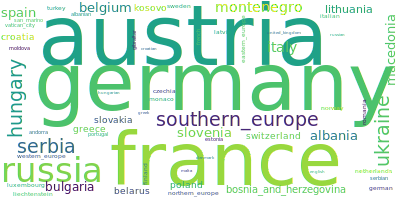

In [13]:
tf.entity_word_cloud()

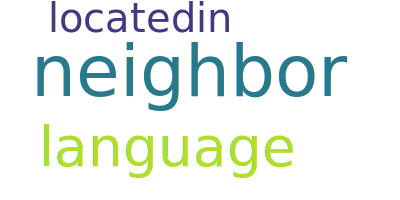

In [14]:
tf.relation_word_cloud()

## Predictions

### Where is Switzerland located?

In [18]:
predict.predict_target(model=model, head="switzerland", relation="locatedin", triples_factory=tf).add_membership_columns(testing=test_tf,training=train_tf).df.head(20)

,tail_id,score,tail_label,in_testing,in_training
91,91,-0.925178,western_europe,False,False
79,79,-1.427510,southern_europe,False,False
46,46,-1.688211,liechtenstein,False,False
28,28,-1.740078,france,False,False
22,22,-1.757504,eastern_europe,False,False
31,31,-1.761142,germany,False,False
84,84,-1.777169,switzerland,False,False
60,60,-1.818136,netherlands,False,False
49,49,-1.853222,luxembourg,False,False
25,25,-1.855138,estonian,False,False


### What languages are spoken in Switzerland? (in addition to what is asserted in the KG)?

In [19]:
# Automatically filter out non-novel predictions (e.g. in training or in testing is True)
predict.predict_target(model=model, head="switzerland", relation="language", triples_factory=tf).filter_triples(test_tf,train_tf).df.head(20)

,tail_id,score,tail_label
40,40,-1.257183,italian
30,30,-1.368249,german
29,29,-1.375735,french
21,21,-1.515512,dutch
77,77,-1.521403,slovene
50,50,-1.600069,luxembourgish
43,43,-1.656561,latin
65,65,-1.674437,polish
35,35,-1.675592,hungarian
17,17,-1.704018,czech


### Which countries are located in Western Europe? (in addition to those asserted in the KG)



In [21]:
predict.predict_target(model=model, tail="western_europe", relation="locatedin", triples_factory=tf).filter_triples(test_tf,train_tf).df.head(20)

,head_id,score,head_label
84,84,-0.925178,switzerland
20,20,-1.257223,denmark
18,18,-1.269357,czechia
41,41,-1.281751,italy
76,76,-1.352949,slovakia
78,78,-1.427589,slovenia
90,90,-1.498115,vatican_city
80,80,-1.498443,spain
36,36,-1.506054,hungary
64,64,-1.536139,poland
